# Time Series Analysis

Goals: Find outliers, trends, and periodicity in MTA turnstile data

Data: MTA subway fares and swipe. 

---
## Load Dataset

In [53]:
import os
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib as plt
import pprint as pprint

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/Ian/anaconda/envs/python36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [54]:
# Download Data if Needed
if os.path.isfile("MTA_Fare.npy"):
    print("File Already Exists.")
    
else: 
    URL = "https://github.com/fedhere/PUI2017_fb55/blob/master/HW10_fb55/MTA_Fare.npy?raw=true"
    urlretrieve(URL, "MTA_Fare.npy")

File Already Exists.


In [55]:
# Load data
data = np.load("MTA_Fare.npy")
data.shape

(600, 23, 194)

In [56]:
# Look at Data Sample
pprint.pprint(data[1])

array([[16210, 20179, 21769, ...,    -1,    -1,    -1],
       [  503,   647,   665, ...,    -1,    -1,    -1],
       [   41,    43,    44, ...,    -1,    -1,    -1],
       ..., 
       [    0,     0,     0, ...,    -1,    -1,    -1],
       [    0,     0,     0, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1]], dtype=int32)


### Note

This data contains 600 stations, 23 types of subway cards, and 194 week of swipe data. Missing data is noted as -1.

In [57]:
# Replace missing values (-1) with NaN

data_fixed = data
data_fixed = data_fixed.astype('float')
data_fixed[data_fixed == -1] = np.NaN    

In [58]:
# Create a timestampe index 

time_idx = pd.date_range('2010-05-21', '2014-01-31', freq = "W-FRI")
print(time_idx.shape)
time_idx[0:10]

(194,)


DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23'],
              dtype='datetime64[ns]', freq='W-FRI')

In [59]:
time_idx[193]

Timestamp('2014-01-31 00:00:00', freq='W-FRI')

---
## Task 1: Event Detection

Identify the most prominent event where there is a significant drop (>3 sigma) in all time series. Find out the dates and provide thoughts on potential reasons.

In [60]:
# Create common dimension variables
stations = data_fixed.shape[0]
cards = data_fixed.shape[1]
weeks = data_fixed.shape[2]

In [61]:
# Find dates when total rides below 3 sigma from the mean

def findOutlier(data_fixed, time_idx):
    
    '''
    This function find all the weeks that has a weekly ridership lower than 3 sigma from the mean of all time.
    The week starts on Fridays with the first week on 2010-05-21 (Friday).
    
    Input: 3D array of the subway swipe data
    Output: A list of dates with ridership lower than 3-sigma threshold
    '''
    OutlierDates = []
    
    # Create a Weekly Sum of All Card Type and Stations
    WeeklySum = []

    for week in range(0, weeks):
        
        daily_total = 0
        
        for station in range(0, stations):
            for card in range(0, cards):
                daily_total = daily_total + np.nansum(data_fixed[station][card][week])
                
        WeeklySum.append(daily_total)
        #print("Total Trip during the Week of {}: {}".format(time_idx[week],daily_total))
        del daily_total
        
    # Find Outliers
    WeeklySum = np.array(WeeklySum)
    threshold = WeeklySum.mean() - 3*WeeklySum.std()
    idx = np.where(WeeklySum < threshold)
    OutlierDates = time_idx[idx]
    
    return OutlierDates 

OutlierDates = findOutlier(data_fixed, time_idx)

In [62]:
print(OutlierDates.values)

['2012-10-19T00:00:00.000000000']


### Discusison

The week of Oct 19, 2012 is when the city was preparing for Hurricane Sandy.

---

## Task 2: Stationarity

Which ridership types have increased and decrease in popularity? And, by how much?

In [63]:
# Define a Dictionary of Ridership Card Names

card_name = {'0':"10 Trips",
            '1':"14 Days",
            '2':"1 Day /FunPass",
            '3':"2 Trip",
            '4':"30 Days",
            '5':'7 Days',
            '6':'ADA Disability',
            '7':'ADA Access Sys.',
            '8':'Express',
            '9':'Easy Pay',
            '10':'Full Fare',
            '11':'Metrocard',
            '12':'Mall and Ride',
            '13':'Monthly',
            '14':'Media Reduced Fare',
            '15':'Rail Road',
            '16':'Senior/Disabled',
            '17':'Special',
            '18':'Transit Check Metro',
            '19':'Ticket',
            '20':'Unlimited',
            '21':'Express',
            '22':'Student'}

In [64]:
def findPopularity(data_fixed):
    '''
    This function returns a list of popularity trend - measured by % change of rolling 10 day averages - by card type. 
    input: subway data with missing values replaced by NaN
    output: a list
    '''    

    # Compute total trips of all stations by card type across 194 weeks
    TotalbyCard = []

    for card in range(0, cards):

        print("Calculating 194 weeks' total Ridership Across all Stations for Card Type: {}".format(card))
        TotalbyWeek = []

        for week in range(0, weeks):

            TotalbyStation = 0

            for station in range(0, stations):
                TotalbyStation = TotalbyStation + np.nansum(data_fixed[station][card][week])

            TotalbyWeek.append(TotalbyStation)
            TotalbyStation = 0

        TotalbyCard.append(TotalbyWeek)
        del TotalbyWeek, TotalbyStation
        
    # Compute 10-day Rolling Average of ridership across 194 weeks of each Card Type
    print("------------------------------------------------------")
    rollingAvg = []

    for card in range(0, cards):
        print("Calculating 10-Day Rolling Average of Total Ridership for Card Type: {}".format(card))
        avg = pd.Series(TotalbyCard[card]).rolling(10).mean()
        rollingAvg.append(avg)
        
    # Calculate % change of 10-day rolling average 
    print("------------------------------------------------------")
    print("Calculate % change of Rolling Averages")
    changeRollAvg = []

    for card in range(0, cards):
        change = []
        for week in range(0, weeks):
            change.append(rollingAvg[card][week]*100 / (rollingAvg[card][9]+1))
        changeRollAvg.append(change)
        del change
        
    return changeRollAvg 

popularity = findPopularity(data_fixed)

Calculating 194 weeks' total Ridership Across all Stations for Card Type: 0
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 1
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 2
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 3
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 4
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 5
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 6
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 7
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 8
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 9
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 10
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 11
Calculating 194 weeks' total Ridership Across all Stations for Card Type: 12
Calculati

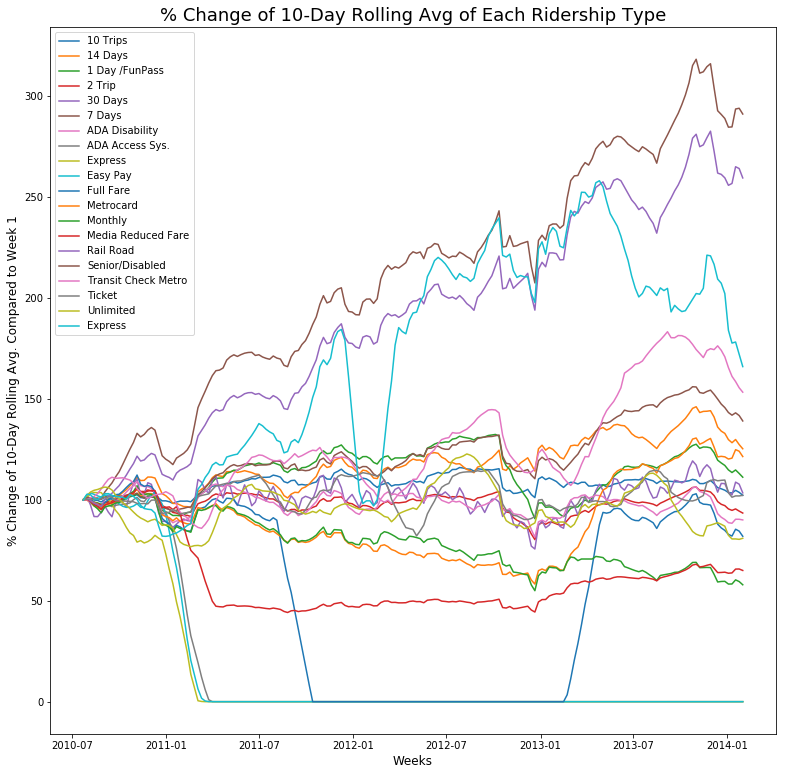

In [65]:
# Visualize
fig = plt.figure(figsize= (13, 13))
ax = fig.add_subplot(111)
for card in range(0, 23):
    # Some Card Type has Sharp Change; will investigate seperately
    if card !=12 and card !=17 and card !=22:
        label_txt = card_name[str(card)]
        ax.plot(time_idx, popularity[card], label=label_txt)
plt.legend();
plt.xlabel("Weeks", size = 12);
plt.ylabel("% Change of 10-Day Rolling Avg. Compared to Week 1", size = 12);
plt.title("% Change of 10-Day Rolling Avg of Each Ridership Type", size = 18);

In [66]:
# Quantitative Measurement between first and last 10-day rolling averages

def findMinMax(popularity):
    import pprint as pprint
    '''
    This function finds the ridership name based on the min/max of % change of last 10-day rolling average / first 10 days
    Input: list of 194 % change of 10-day Rolling Average of 23 riderships
    Return: strings of the ridership
    
    '''
    
    last_RA = {}
    for card in range(0, cards):
        last_RA[card_name[str(card)]] = popularity[card][-1] 
        
    sorted_list = [(k, last_RA[k]) for k in sorted(last_RA, key = last_RA.get, reverse = True)]
    print('--- Sorted List of Ridership based on % Change of Last 10 Days over First 10 Days ---')
    pprint.pprint(sorted_list) 

findMinMax(popularity)


--- Sorted List of Ridership based on % Change of Last 10 Days over First 10 Days ---
[('Student', 106853960.00000001),
 ('Mall and Ride', 2114008.823529412),
 ('Special', 7002.8131868131868),
 ('Senior/Disabled', 290.93035476263714),
 ('Rail Road', 259.29196955841098),
 ('Express', 165.88432523051131),
 ('Transit Check Metro', 153.22583847971563),
 ('7 Days', 138.97472503781228),
 ('14 Days', 125.20627053424856),
 ('Metrocard', 121.35313558878677),
 ('1 Day /FunPass', 111.13228683825017),
 ('30 Days', 103.37655242591312),
 ('10 Trips', 102.17978431947429),
 ('Ticket', 102.15406892831285),
 ('2 Trip', 93.379846140529878),
 ('ADA Disability', 89.984124282558469),
 ('Full Fare', 81.878228326130326),
 ('Unlimited', 80.894180133689431),
 ('Media Reduced Fare', 64.960766172453958),
 ('Monthly', 57.871816946278663),
 ('ADA Access Sys.', 0.020942789761707475),
 ('Easy Pay', 0.00015019532902539755)]


## Caption 1

This is a time series plot of % change of 10-day rolling average compare to week 1 of each ridership type. Rider using Senior / Disabled tickets seemed to have grown by 3 times (290%) between 2010 to 2014. In contrast, riders using Monthly pass seemed to decline drastically. It has reduced by half in 2014 (57% of first week).

Some ridership types, such as Express and Rail Road, reduced to zero. They may be discontinued. There is a discontinuity of full fare ridership between late 2011 and early 2013. This may due to system or access issues.

Special cases with large growth (% change over 300%) will be discussed below.

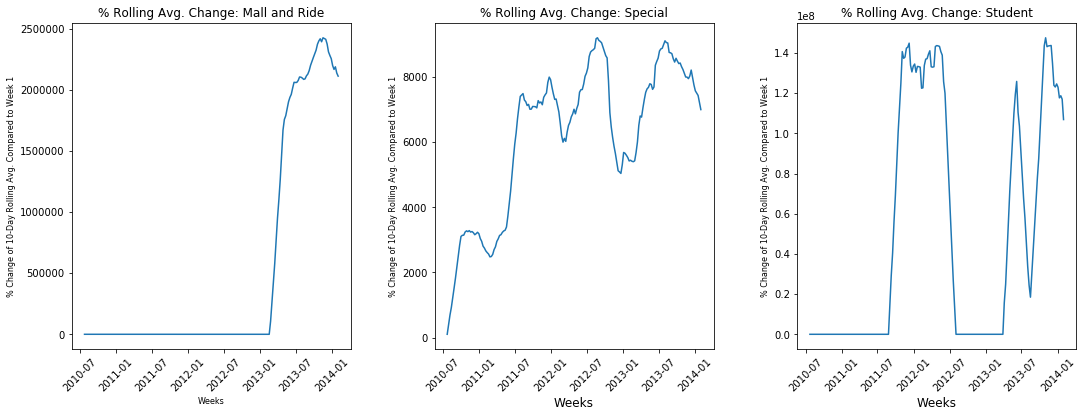

In [67]:
# Special Cases

fig = plt.figure(figsize= (18, 6))
fig.subplots_adjust(wspace=.3)

ax = fig.add_subplot(131)
card = 12
label_txt = card_name[str(card)]
ax.plot(time_idx, popularity[card], label=label_txt)
plt.xticks(rotation = 45);
plt.xlabel("Weeks", size = 8);
plt.ylabel("% Change of 10-Day Rolling Avg. Compared to Week 1", size = 8);
plt.title("% Rolling Avg. Change: "+label_txt);

ax = fig.add_subplot(132)
card = 17
label_txt = card_name[str(card)]
ax.plot(time_idx, popularity[card], label=label_txt)
plt.xticks(rotation = 45);
plt.xlabel("Weeks", size = 12);
plt.ylabel("% Change of 10-Day Rolling Avg. Compared to Week 1", size = 8);
plt.title("% Rolling Avg. Change: "+label_txt);

ax = fig.add_subplot(133)
card = 22
label_txt = card_name[str(card)]
ax.plot(time_idx, popularity[card], label=label_txt)
plt.xticks(rotation = 45);
plt.xlabel("Weeks", size = 12);
plt.ylabel("% Change of 10-Day Rolling Avg. Compared to Week 1", size = 8);
plt.title("% Rolling Avg. Change: "+label_txt);

## Caption 2

These are % change in rolling average compare to week 1 analysis for special cases. Each case shows abrupt change in ridership in some point in time. 

In the cases of "Mall and Ride" and "Special" tickets, the data suggests that the MTA introduced these new riderships within our window of analysis. Hence, there are very high % changes in rolling averages. These two are special cases. They should be baselined and analyzed using a different 194-week time window.

In the case of "Student" ridership, the spikes and dips signifies periodic sales and discountinuity. Therefore, it may not be suitable for the same growh analysis.

---

# Task 3: Periodicity

In [68]:
def getRidersStation(data_fixed): 
    # Compute total trips of all stations by card type across 194 weeks
    TotalbyStation = []

    for station in range(0, stations):

        TotalbyWeek = []

        for week in range(0, weeks):

            TotalbyCard = 0

            for card in range(0, cards):
                TotalbyCard = TotalbyCard + np.nansum(data_fixed[station][card][week])

            TotalbyWeek.append(TotalbyCard)
            TotalbyCard = 0

        TotalbyStation.append(TotalbyWeek)
        del TotalbyWeek, TotalbyCard

    return TotalbyStation

TotalbyStation = getRidersStation(data_fixed)

In [69]:
# Create a list of real fourier transform
fourier = []
for station in range(0, stations):
    f = np.abs(np.fft.rfft(TotalbyStation[station]))
    fourier.append(f)


/Users/Ian/anaconda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


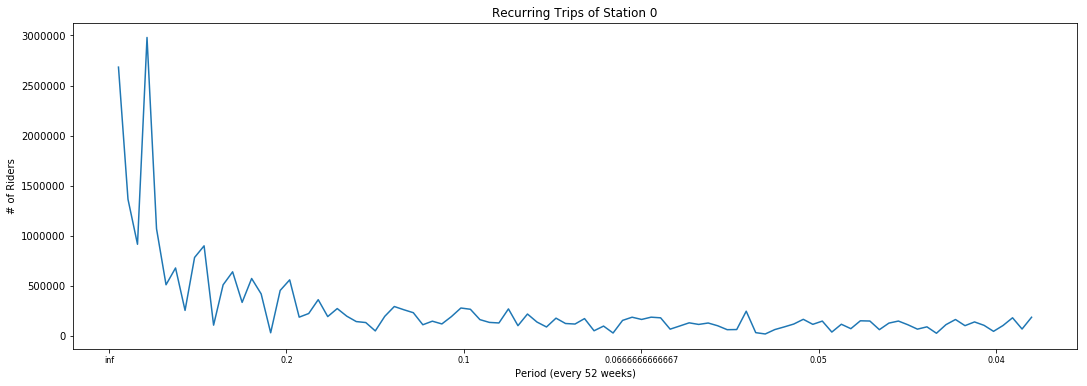

In [70]:
# Sample Plot to Understand Fourier Transform of Station 0

N = len(TotalbyStation[0])
sample_rate = 52
period = np.fft.rfftfreq(N, 1.0/sample_rate)

fig = plt.figure(figsize= (18, 6));
ax = fig.add_subplot(111);
f = fourier[0];
ax.plot(freq[1:], f[1:]);
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=8);
ax.set_xlabel("Period (every 52 weeks)");
ax.set_ylabel("# of Riders");
ax.set_title("Recurring Trips of Station 0");

In [71]:
# Understand Period
period

# period[4] is about 1.07 which is 52 weeks 

array([  0.        ,   0.26804124,   0.53608247,   0.80412371,
         1.07216495,   1.34020619,   1.60824742,   1.87628866,
         2.1443299 ,   2.41237113,   2.68041237,   2.94845361,
         3.21649485,   3.48453608,   3.75257732,   4.02061856,
         4.28865979,   4.55670103,   4.82474227,   5.09278351,
         5.36082474,   5.62886598,   5.89690722,   6.16494845,
         6.43298969,   6.70103093,   6.96907216,   7.2371134 ,
         7.50515464,   7.77319588,   8.04123711,   8.30927835,
         8.57731959,   8.84536082,   9.11340206,   9.3814433 ,
         9.64948454,   9.91752577,  10.18556701,  10.45360825,
        10.72164948,  10.98969072,  11.25773196,  11.5257732 ,
        11.79381443,  12.06185567,  12.32989691,  12.59793814,
        12.86597938,  13.13402062,  13.40206186,  13.67010309,
        13.93814433,  14.20618557,  14.4742268 ,  14.74226804,
        15.01030928,  15.27835052,  15.54639175,  15.81443299,
        16.08247423,  16.35051546,  16.6185567 ,  16.88

In [72]:
# Find the Power at freq = 1 (every 52 weeks)

power52 = []

def findPower(fourier):
    import pprint as pprint
    '''
    This function finds the power of the fft and returns the power at period ~ 1 (every 52 weeks)
    Input: a list of fourier transformed ridership amount by station
    Output: print out top x station with highest periodic peak at every 52 weeks
    
    '''
    
    power = {}
    for station in range(0, stations):
        power[str(station)] = fourier[station][4]
        
    sorted_list = [(k, power[k]) for k in sorted(power, key = power.get, reverse = True)]
    print('--- the First 4 Station with the Highest Periodic Peak in an Annual Period ---')
    pprint.pprint(sorted_list[:4]) 

findPower(fourier)


--- the First 4 Station with the Highest Periodic Peak in an Annual Period ---
[('0', 2980160.6355953491),
 ('194', 2950388.929214194),
 ('150', 2931895.8769513383),
 ('327', 2402218.5809588567)]


### Discussion

This 52-week periodic peak may be due to holiday such as Memorial Day in every May. 